In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from google.cloud import bigquery
import db_dtypes
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
os.environ[
    "GOOGLE_APPLICATION_CREDENTIALS"] = "the-webbing-454111-s0-9a04cc92eadc.json"  # lokalizacja pobranego klucza z punktu 1.4.
client = bigquery.Client()

In [49]:
query = """
SELECT DISTINCT
    country_name,
    iso_3166_1_alpha_3 AS `3 letter country code`,
    AVG(new_deceased) AS `new_deceased`,
    AVG(new_confirmed) AS `new_confirmed`,
    AVG(new_persons_vaccinated) AS `new_persons_vaccinated`,
    MAX(new_tested) as `new_tested`,
    MAX(population) AS `population`, 
    MAX(stringency_index) AS `stringency_index`,
    MAX(gdp_usd) AS `GDP`, 
    MAX(health_expenditure_usd) AS `health_expenditure_usd`,
    AVG(population_density) AS `population density`,
    MAX(life_expectancy) AS `life_expectancy`, 
    CASE 
        WHEN SUM(new_confirmed) = 0 THEN 0 
        ELSE (SUM(new_deceased) * 100) / SUM(new_confirmed) 
    END AS `Deceased to Confirmed cases %`, 
    date,
FROM 
    `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE 
    aggregation_level = 0
GROUP BY 
    country_name, iso_3166_1_alpha_3, date
ORDER BY 
    country_name
"""
query_disease = client.query(query)
query_disease_result = query_disease.result()
disease_df = query_disease_result.to_dataframe()
#disease_df.dropna(inplace=True)
disease_df.to_csv('results\\prepared_for_3_ex.csv', index=False)


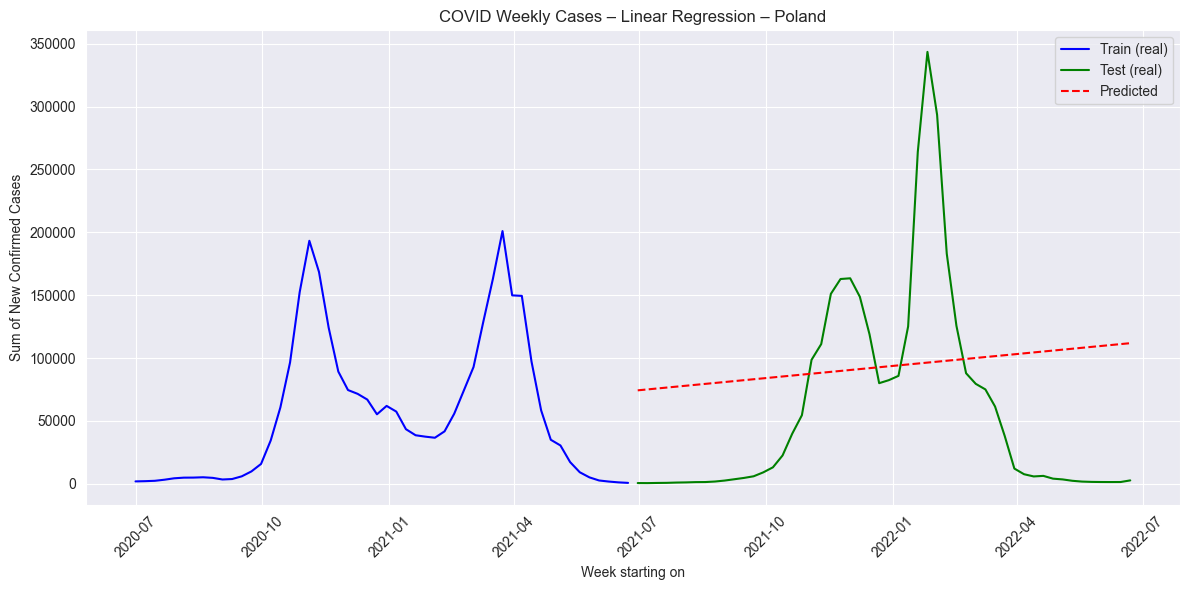

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_confirmed': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 51]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 51) & (weekly_df['week'] <= 103)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_confirmed']
X_test = test_weeks[['week']]
y_test = test_weeks['new_confirmed']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New Confirmed Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<h1>Jak widać, do takich zastosowań jak ilość nowych przypadków, regresja liniowa nie jest w stanie się odpowiednio dopasować - jest to zrozumiałe bo jest to funkcja liniowa, a wiadomo, że nowe zachorowania nie będą się zachowywać w sposób liniowy.<h1>

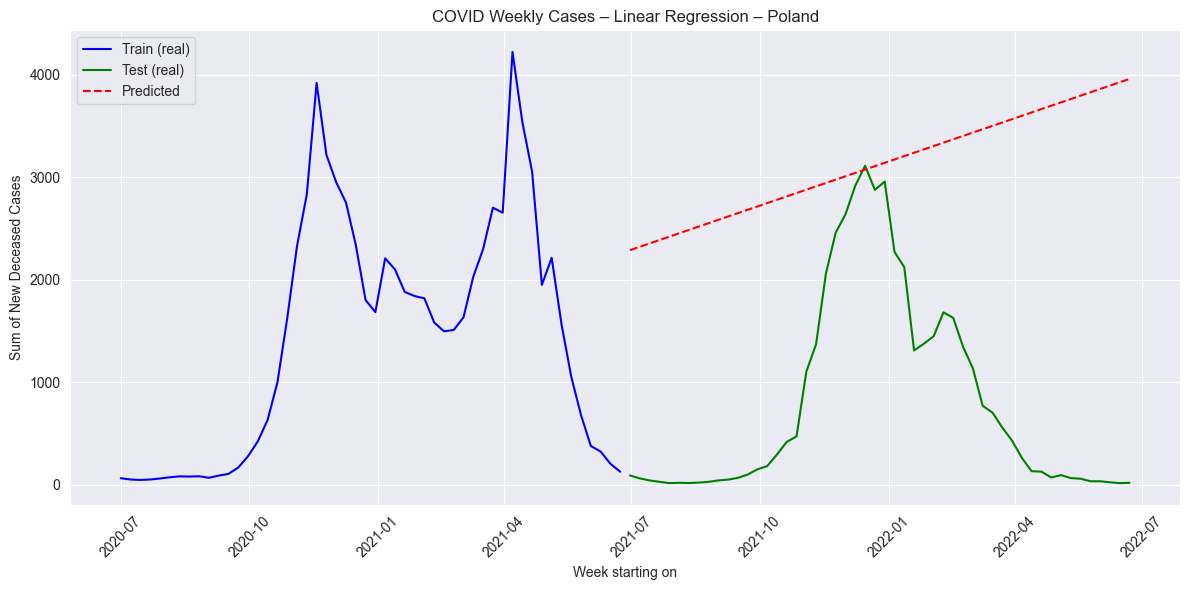

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_deceased': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 51]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 51) & (weekly_df['week'] <= 103)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_deceased']
X_test = test_weeks[['week']]
y_test = test_weeks['new_deceased']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New Deceased Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


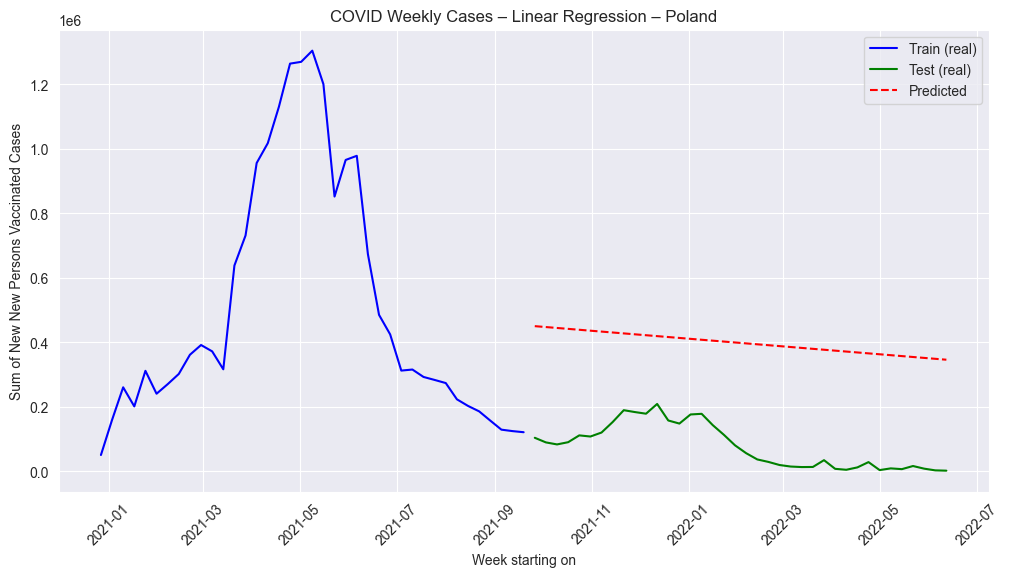

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-12-27') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_persons_vaccinated': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 38]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 38) & (weekly_df['week'] <= 76)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_persons_vaccinated']
X_test = test_weeks[['week']]
y_test = test_weeks['new_persons_vaccinated']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New Persons Vaccinated Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


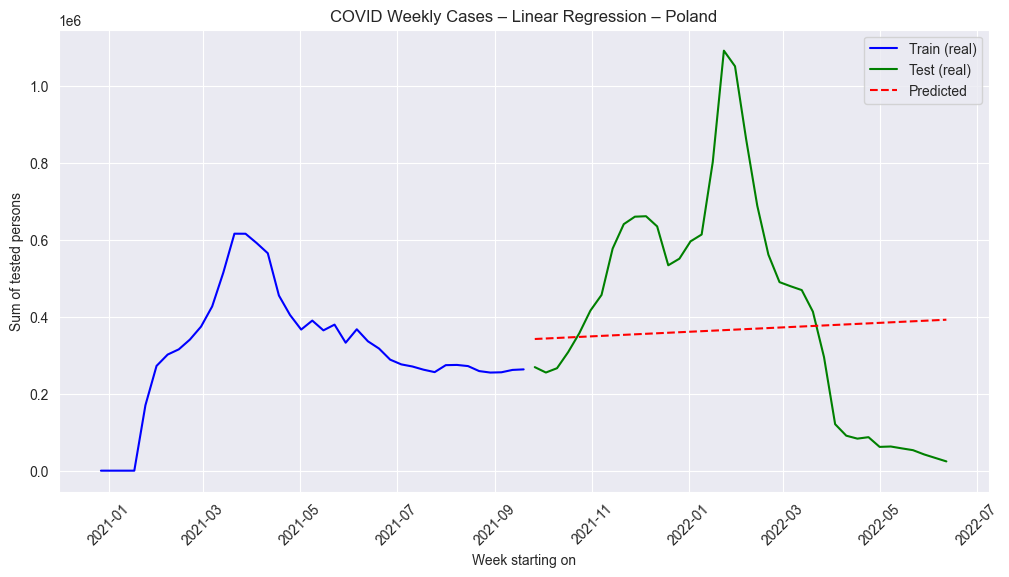

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-12-27') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_tested': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 38]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 38) & (weekly_df['week'] <= 76)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_tested']
X_test = test_weeks[['week']]
y_test = test_weeks['new_tested']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of tested persons')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


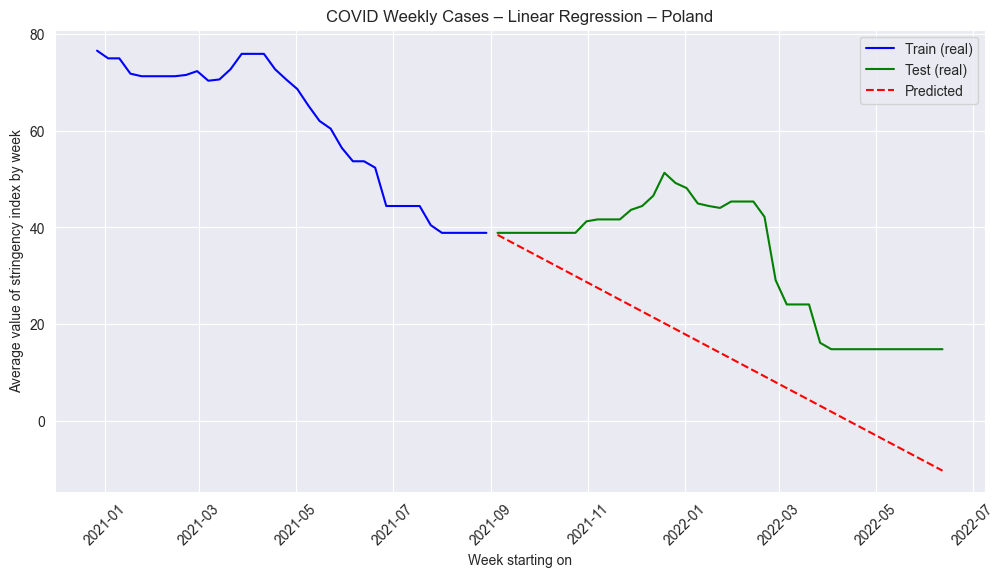

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-12-27') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'stringency_index': 'mean',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 38]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 38) & (weekly_df['week'] <= 76)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['stringency_index']
X_test = test_weeks[['week']]
y_test = test_weeks['stringency_index']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Average value of stringency index by week')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


<h1>Widać że tutaj regresja poradziła sobie w sposób trafny. Jendak np. model ten jest za mało zaawansowany aby odcinać wyniki poniżej 0.<h1>

<h1>Nastepnie przeanalizujemy wynik dla przypadku z nowymi zaszczepieniami. Widać było że regresja poległa, źle dobierając wartość wolnego wyrazu b ze wzoru funkcji liniowej, jednak z racji na "liniowość" danych w odpowiednim zakresie czasu, możemy tak dobrać nasze dane, że model poradzi sobie lepiej:<h1>


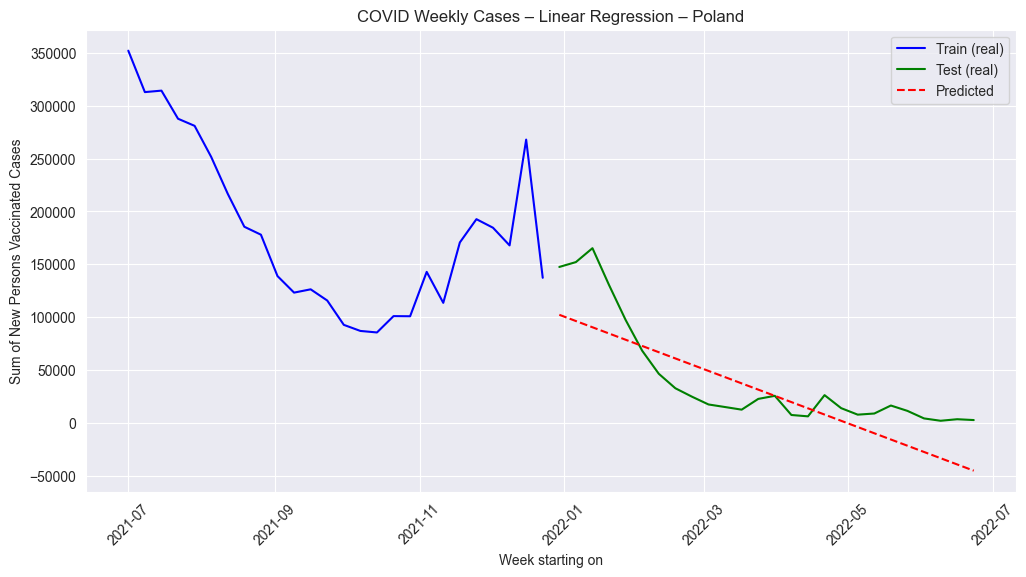

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2021-07-01') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_persons_vaccinated': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 25]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 25) & (weekly_df['week'] <= 51)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_persons_vaccinated']
X_test = test_weeks[['week']]
y_test = test_weeks['new_persons_vaccinated']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New Persons Vaccinated Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


<h1>Jak widać na mniejszym zakresie czasu, jesteśmy w stanie zauważyć poprawność działania i całkiem dobre dopasowanie modelu regresji lioniowej. Niewątpliwie jednak, nie jest to najlepsza metoda dopasowania ani predykcji danych, które nie cechują się liniową charakterystyką. Jednakże, warto ją stosować dla zjawisk cechujących się liniową zależnością: np. siła wyporu od objętości wypartej cieczy itp...  <h1>

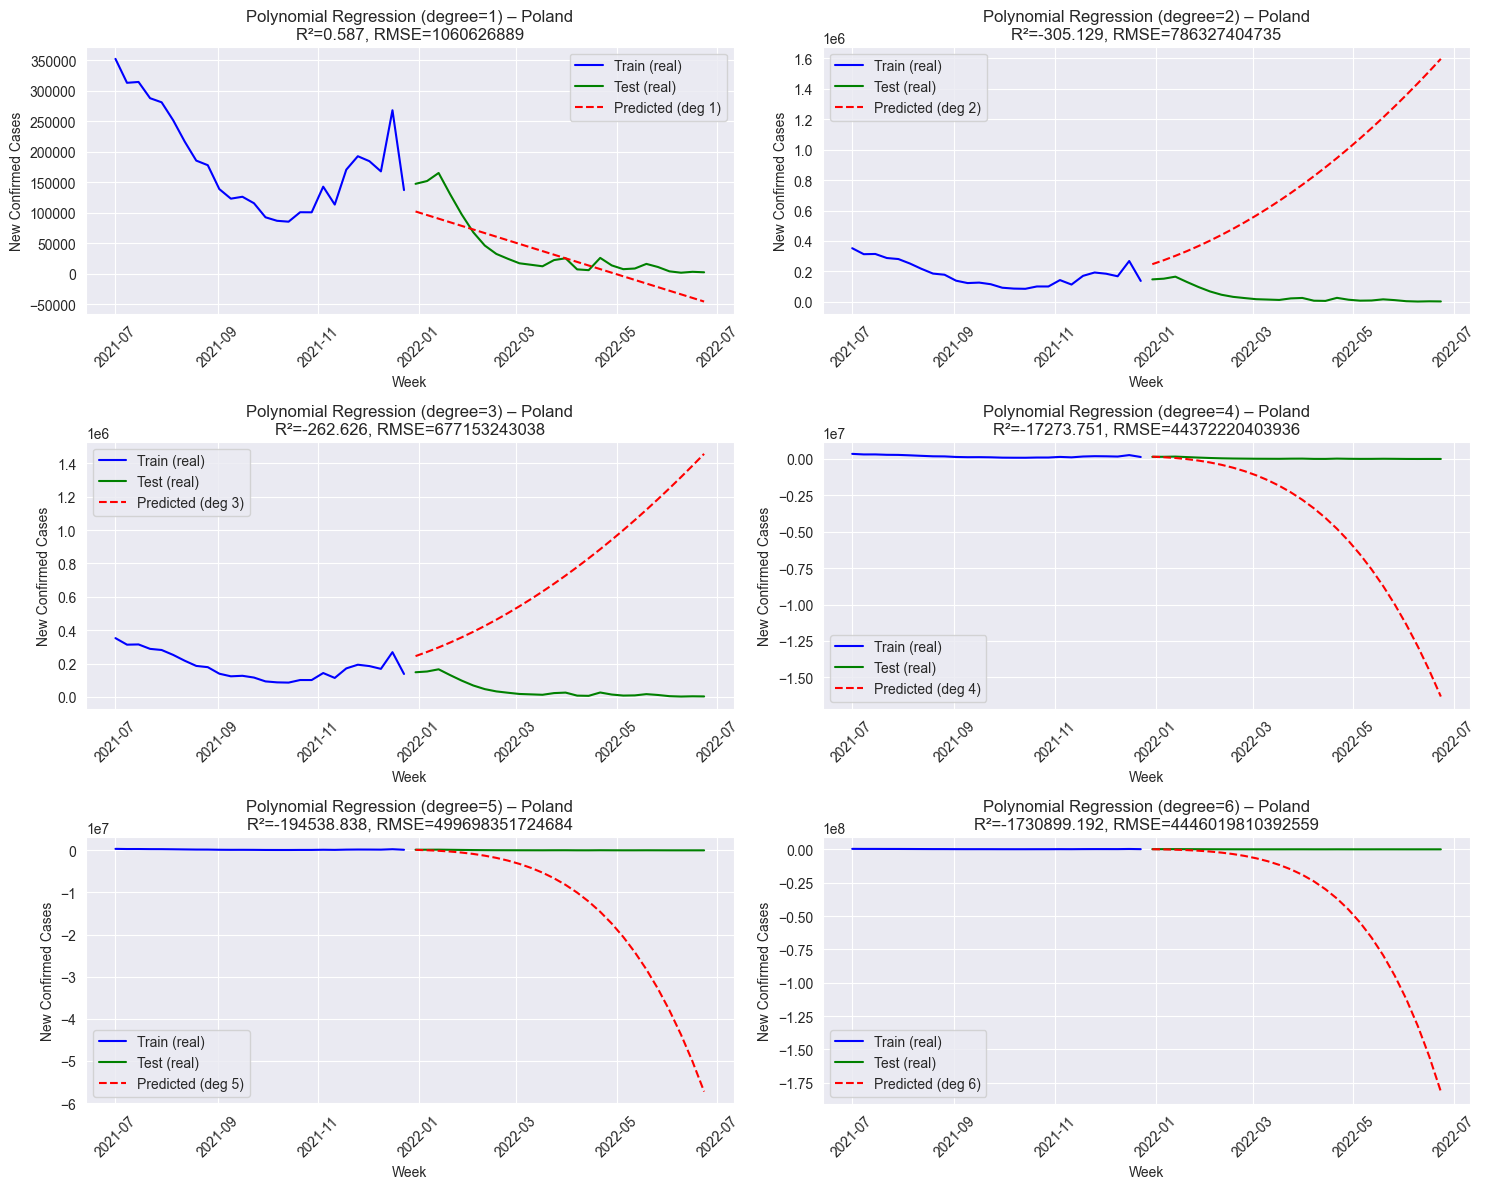

Degree 1: RMSE = 1060626888.64, R² = 0.587
Degree 2: RMSE = 786327404734.67, R² = -305.129
Degree 3: RMSE = 677153243037.68, R² = -262.626
Degree 4: RMSE = 44372220403936.20, R² = -17273.751
Degree 5: RMSE = 499698351724683.69, R² = -194538.838
Degree 6: RMSE = 4446019810392559.00, R² = -1730899.192


In [66]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Zakres stopni do przetestowania
degrees = [1, 2, 3, 4, 5, 6]
results = []

plt.figure(figsize=(15, 12))

for i, degree in enumerate(degrees, start=1):
    # Przekształcenie cech
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Trening modelu
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred_poly = model.predict(X_test_poly)

    # Metryki
    rmse = mean_squared_error(y_test, y_pred_poly)
    r2 = r2_score(y_test, y_pred_poly)
    results.append((degree, rmse, r2))

    # Wykres
    plt.subplot(3, 2, i)
    plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
    plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
    plt.plot(test_weeks['date'], y_pred_poly, label=f'Predicted (deg {degree})', linestyle='--', color='red')
    plt.title(f'Polynomial Regression (degree={degree}) – {country}\nR²={r2:.3f}, RMSE={rmse:.0f}')
    plt.xlabel('Week')
    plt.ylabel('New Confirmed Cases')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# Porównanie wyników
for deg, rmse, r2 in results:
    print(f"Degree {deg}: RMSE = {rmse:.2f}, R² = {r2:.3f}")


<h1> Powyższy przykład w dobitny sposób pokazuje, iż model regresji wielomianowej nie powinien służyć do przewidywania danych "w przyszłości". Wynika to z prostego powodu, są to modele dobierające wartości współczynnków do wielomianu stopnia n. Metody uczenia modelu operają się na minimalizowaniu najczęściej kwadratu odległości punktów rzeczywistych, od tych obliczonych na podstawie wielomianu. Obszary które nie zostały objęte uczeniem (np. obszar testowy z powyższych testów) posiadają wyższą wartość "x" a co za tym idzie coraz to większe potęgi tych liczb. 

Jeżeli chcemy zastosować model regresji wielomianowej, należy podzielić zbiór w inny sposób - wybierać np. co drugi dzień(tydzień) raz do zbioru uczącego a raz do testowego. W ten sposób dalsze "x" nie będą powodować astronomiczych wartości y, a będą również starać się dopasować do kształtu modelowanego zjawiska. 

Finlandia Kongo?